In [125]:
import os
import glob
from tensorflow.keras.applications import MobileNetV2# ใช้ MobileNetV2 (เร็วที่สุด)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models
import tensorflow as tf


# ตรวจสอบโครงสร้างโฟลเดอร์
def check_dataset_structure(base_path):
    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path):
            file_count = len(glob.glob(os.path.join(folder_path, "*.jpg"))) + \
                        len(glob.glob(os.path.join(folder_path, "*.png")))
            print(f"Folder: {folder} - Files: {file_count}")

# ตรวจสอบข้อมูล
check_dataset_structure("DataSet/Processing/models/train")
check_dataset_structure("DataSet/Processing/test")
check_dataset_structure("DataSet/Processing/extra")

Folder: single_class - Files: 26721
Folder: test - Files: 13068
Folder: extra - Files: 202353


In [126]:
import os
import shutil
import random
from tqdm import tqdm

# พาธต้นทางและปลายทาง
SOURCE_DIR = 'DataSet/Processing/train/train'
DEST_DIR = 'DataSet/Processing/models'

# สัดส่วน train / val
train_ratio = 0.8  # หรือเปลี่ยนได้ เช่น 0.7
val_ratio = 1 - train_ratio

# สุ่มเพื่อให้ผลลัพธ์เหมือนเดิม
random.seed(42)

# ดึงไฟล์ทั้งหมดที่เป็นภาพ
image_files = [f for f in os.listdir(SOURCE_DIR) if f.endswith(('.jpg', '.jpeg', '.png'))]
random.shuffle(image_files)

# แบ่งข้อมูล
total = len(image_files)
train_count = int(total * train_ratio)

splits = {
    'train': image_files[:train_count],
    'validation': image_files[train_count:]
}

# คัดลอกไฟล์ไปยังโฟลเดอร์ใหม่
for split, files in splits.items():
    target_dir = os.path.join(DEST_DIR, split, 'single_class')  # class เดียว
    os.makedirs(target_dir, exist_ok=True)
    
    for f in tqdm(files, desc=f"{split}"):
        src = os.path.join(SOURCE_DIR, f)
        dst = os.path.join(target_dir, f)
        shutil.copyfile(src, dst)


train:   0%|          | 0/26721 [00:00<?, ?it/s]

validation: 100%|██████████| 6681/6681 [00:00<00:00, 31170.97it/s]


In [ ]:
# Data generator สำหรับ train พร้อม augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Data generator สำหรับ validation (ไม่ต้องทำ augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Data generator สำหรับ test
test_datagen = ImageDataGenerator(rescale=1./255)

# โหลด training data
train_generator = train_datagen.flow_from_directory(
    'DataSet/Processing/models/train',   # 🔹 path ไปยังโฟลเดอร์ train
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

# โหลด validation data
validation_generator = validation_datagen.flow_from_directory(
    'DataSet/Processing/models/validation',   # 🔹 path ไปยังโฟลเดอร์ validation
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# โหลด test data
test_generator = test_datagen.flow_from_directory(
    'DataSet/Processing/test',    # 🔹 path ไปยังโฟลเดอร์ test
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)


Found 26721 images belonging to 1 classes.
Found 6681 images belonging to 1 classes.
Found 13068 images belonging to 1 classes.


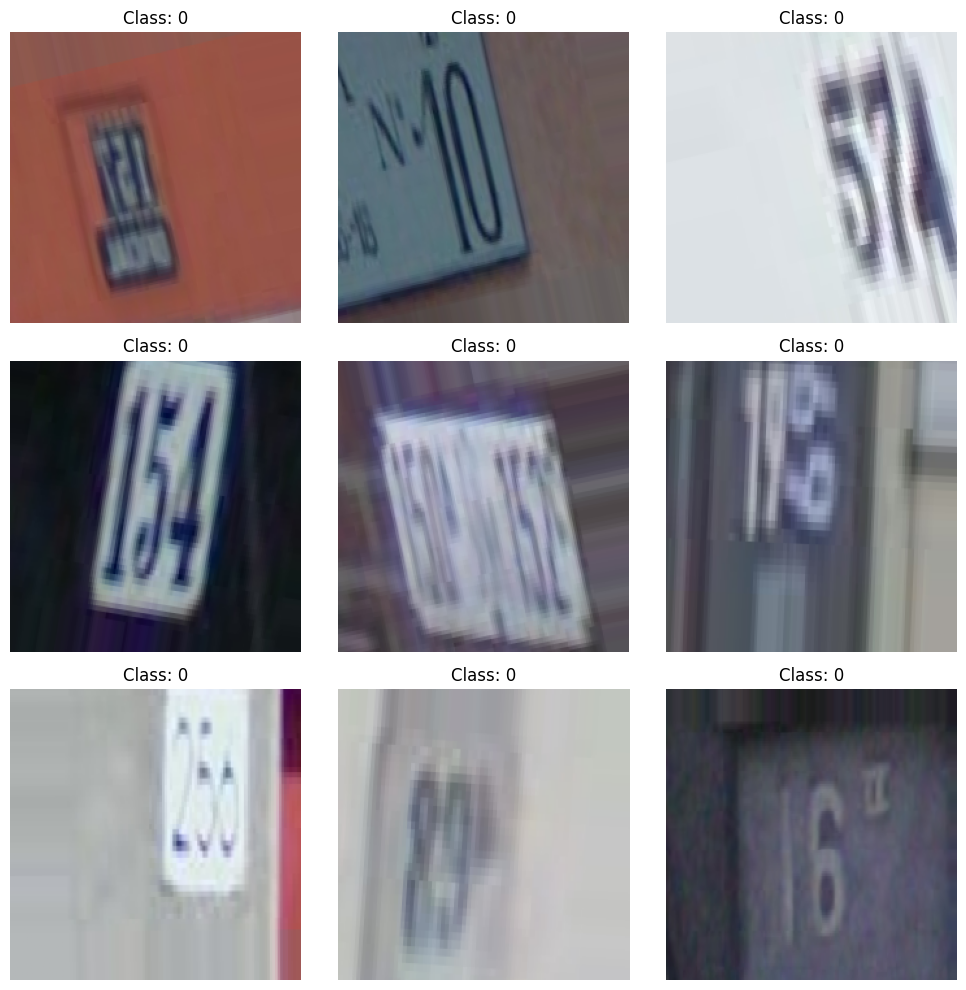

In [127]:
import matplotlib.pyplot as plt
import numpy as np

# ดึง batch แรกจาก train_generator
images, labels = next(train_generator)

# แสดงภาพ 9 รูปแรกใน batch
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Class: {np.argmax(labels[i])}")
    plt.axis('off')
plt.tight_layout()
plt.show()

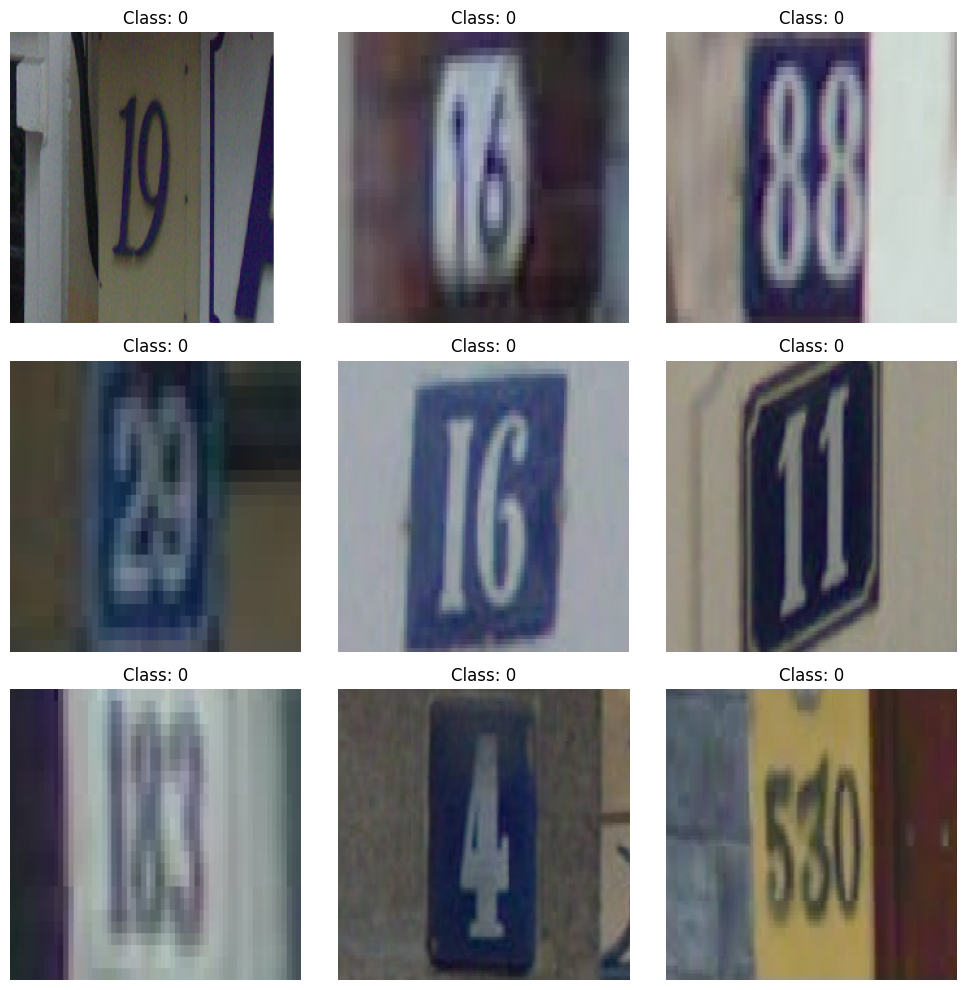

In [128]:

images, labels = next(validation_generator)
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.title(f"Class: {np.argmax(labels[i])}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [129]:
# ดูจำนวน classes
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")
print(f"Class names: {list(train_generator.class_indices.keys())}")

Number of classes: 1
Class names: ['single_class']


In [130]:


base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

In [131]:
# Freeze base model
base_model.trainable = False

In [132]:
# สร้าง model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(224, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(train_generator.class_indices), activation='softmax')
])

In [133]:
# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [134]:
# Callbacks สำหรับหยุดเร็ว
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.0001
)

In [135]:
print(train_generator.samples)
print(validation_generator.samples)
print(test_generator.samples)

26721
6681
13068


In [136]:
print(train_generator.class_indices)

{'single_class': 0}


In [137]:
# เทรน model (เร็วมาก!)
print("Starting training...")
history = model.fit(
    train_generator,
    epochs=10,  # เพียง 10 epochs
    validation_data=validation_generator,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print(f"Training completed!")
print(f"Final validation accuracy: {max(history.history['val_accuracy']):.4f}")

Starting training...


/home/nanashi/AMyFile/CodeHUB/PythonHUB/Supervised_Machine_Learinng/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/home/nanashi/AMyFile/CodeHUB/PythonHUB/Supervised_Machine_Learinng/myenv/lib/python3.12/site-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/home/nanashi/AMyFile/CodeHUB/PythonHUB/Supervised_Machine_Learinng/myenv/lib/python3.12/site-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


  7/418 ━━━━━━━━━━━━━━━━━━━━ 3:57 577ms/step - accuracy: 1.0000 - loss: 0.0000e+00

KeyboardInterrupt: 